## Abstract

Despite the header being `## Abstract`, this section will render as a highlighted section titled *Summary*. Ensure this section is a **maximum** of 280 characters.

----

:::{.callout-note title="AI usage disclosure" collapse="true"}
This is a placeholder for the AI usage disclosure. Once all authors sign the AI code form on Airtable, SlackBot will message you an AI disclosure that you should place here.
:::

## Purpose

Once edited by you, this file will become your publication. Alternatively, if you already have a notebook written that you're trying to transform into a pub, replace this file with your own, but be sure to add the YAML front matter (the first cell) to your notebook.

Your pub should begin with a section titled **Purpose** where you, as briefly as possible, explain why you did the work described in the pub, the key takeaway, your primary audience, and how you think it could be useful to them/why you're sharing it.

## Introduction

MSA Pairformer achieves state-of-the-art performance in protein structure and function prediction, largely due to its innovative query-biased attention mechanism [@Akiyama2025]. The authors put forward a compelling hypothesis for this success: by learning to weight sequences based on their evolutionary relevance, the model mitigates phylogenetic averaging and amplifies faint, subfamily-specific signals.

The original paper supported this by showing the model's attention weights could separate subfamilies. While compelling, this was not a fully-fledged characterization of how sequence weights map onto phylogenetic structure, and was demonstrated for just one protein family---a response regulator family. This leaves open the question of how precisely, and how generally, the model's attention mechanism recapitulates evolutionary relatedness.

In this work, we explore these questions directly. We begin by revisiting the response regulator family to ground our analysis, and then expand our investigation to thousands of MSAs across the tree of life. Our goal is to scope out the anatomy of the model's evolutionary understanding on a broad scale.

## Revisiting the response regulator study

The response regulator (RR) family was the original paper's showcase for demonstrating the power of query-biased attention. By constructing a mixed MSA of [GerE](https://www.ebi.ac.uk/interpro/entry/pfam/PF00196/), [LytTR](https://www.ebi.ac.uk/interpro/entry/pfam/PF04397/), and [OmpR](https://www.ebi.ac.uk/interpro/entry/pfam/PF00486/) subfamilies, the authors showed MSA Pairformer could successfully identify key structural contacts unique to each subfamily.

They illustrated the mechanism behind this success by plotting model sequence weights against Hamming distance[^hamming], revealing that members of the query's subfamily were consistently upweighted, as shown below.

![Figure 4B from @Akiyama2025. Original caption: "*Median sequence weight across the layers of the model versus Hamming distance to the query sequence. Top panels show distribution of sequence attention weights for subfamily members (red) and non-subfamily sequences (grey). Grey dotted line indicates weights used for uniform sequence attention and red dotted line indicates weight assigned to the query sequence.*"](assets/figure4b.jpg){fig-align="center" width=100% fig-alt="Figure 4B from @Akiyama2025 showing the relationship between median sequence weight and Hamming distance to the query."}

We can build on this analysis by replacing the proxy of Hamming distance with a formal phylogenetic tree, which would allow us to ask a more nuanced question: Do the model's sequence weights reflect the continuous distances of evolutionary history, or do they simply create a binary distinction between "in-group" and "out-group"?

To ground our phylogenetic analysis in the paper's original findings, we start by replicating the dataset. Following the protocol laid out by @Akiyama2025, we begin by downloading the full PFAM alignments for the GerE, LytTR, and OmpR subfamilies, combining them, and then sampling a final set of 4096 sequences to match the dataset used in the study.

[^hamming]: Hamming distance is the number of positions at which two sequences of equal length differ.

In [ ]:
# | echo: false
# | output: false
%env TQDM_DISABLE_NOTEBOOK=0
%env USE_MODAL=1
%load_ext autoreload
%autoreload 2

:::{.callout-note title="Reproducing the response regulator MSAs"}

@Akiyama2025 qualitatively describe how to reproduce the response regulator MSAs, however these details are insufficient for exact replication. The code below is our attempted reproduction, and we find these MSAs yield similar, yet not identical, sequence weight statistics.

In [ ]:
# | code-fold: true
# | code-summary: Response regulator MSA code

from collections import Counter
from pathlib import Path

import pandas as pd
from analysis.pfam import download_and_process_response_regulator_msa

from MSA_Pairformer.dataset import MSA

response_regulator_dir = Path("./data/response_regulators")
response_regulator_dir.mkdir(parents=True, exist_ok=True)

rr_msas: dict[str, MSA] = {}

rr_queries = {"1NXS": "OmpR", "4CBV": "LytTR", "4E7P": "GerE"}
for query in rr_queries:
    msa_path = response_regulator_dir / f"PF00072.final_{query}.a3m"

    if not msa_path.exists():
        download_and_process_response_regulator_msa(
            output_dir=response_regulator_dir,
            subset_size=4096,
        )

    rr_msas[query] = MSA(msa_file_path=msa_path, diverse_select_method="none")

example_msa = rr_msas[query]
membership_path = response_regulator_dir / "membership.txt"
target_to_subfamily = (
    pd.read_csv(membership_path, sep="\t").set_index("record_id")["subfamily"].to_dict()
)

print(f"MSA has {len(example_msa.ids_l)} sequences:")

subfamily_member_count = Counter()
for sequence in example_msa.ids_l:
    subfamily_member_count[target_to_subfamily[sequence]] += 1

for subfamily, count in subfamily_member_count.items():
    print(f"  - {subfamily} sequences: {count}")


:::

To infer a tree for this MSA, we use [FastTree](https://morgannprice.github.io/fasttree/), a rapid method for approximating maximum-likelihood phylogenies suitable for trees of this size [@Price2009].

In [ ]:
# | code-fold: true
# | code-summary: Tree inference code

from analysis.tree import read_newick, run_fasttree

fasttree_path = response_regulator_dir / "PF00072.final.fasttree.newick"
msa_for_tree = response_regulator_dir / "PF00072.final.fasta"
if not fasttree_path.exists():
    run_fasttree(msa_path.with_suffix(".fasta"), fasttree_path)

rr_tree = read_newick(fasttree_path)


Visualizing this tree provides our first direct look at the evolutionary structure of the data.

In [ ]:
# | code-fold: true
# | code-summary: Tree visualization code
# | label: fig-rr-tree
# | fig-cap: A randomly selected subset of the response regulator family illustrating the tree structure. The RSCB structure ID is labelled for the query sequence of each subfamily. Leaves are colored according to subfamily  ([⬤]{style="color:#5088C5"} [GerE](https://www.ebi.ac.uk/interpro/entry/pfam/PF00196/), [⬤]{style="color:#F28360"} [OmpR](https://www.ebi.ac.uk/interpro/entry/pfam/PF00486/), [⬤]{style="color:#3B9886"} [LytTR](https://www.ebi.ac.uk/interpro/entry/pfam/PF04397/)).

import arcadia_pycolor as apc
from analysis.plotting import tree_style_with_categorical_annotation
from analysis.tree import read_newick, subset_tree

query_colors = {
    "4E7P": apc.aegean,
    "1NXS": apc.amber,
    "4CBV": apc.seaweed,
}
subfamily_colors = {rr_queries[k]: v for k, v in query_colors.items()}

tree_style = tree_style_with_categorical_annotation(
    categories=target_to_subfamily,
    highlight=list(rr_queries),
    color_map=subfamily_colors,
)
visualized_tree = subset_tree(tree=rr_tree, n=100, force_include=list(rr_queries), seed=42)
visualized_tree.render("%%inline", tree_style=tree_style, dpi=300)

We expect to see distinct, well-supported clades corresponding to the three subfamilies, which is more or less what we observe in @fig-rr-tree. Discrepancies from this expectation highlight the importance of clade grouping based on explicit tree calculation, rather than relying on PFAM domains. 

To compare against our phylogenetic "ground truth," we need to generate the model's query-biased sequence weights, which are hypothesized to capture evolutionary relatedness. To do this, we'll run an MSA Pairformer inference three separate times. Each run will use a different subfamily representative as the query, yielding three distinct, query-biased sets of sequence weights.

:::{.callout-note title="Running MSA Pairformer..."}
In order to reproduce this step of the workflow, you'll need a GPU with at least 40Gb of GPU VRAM. We don't assume you have that hardware handy, so we've stored pre-computed inference results (`data/response_regulators/inference_results.pt`), and by default, the code below will load these inference results rather than re-computing. If you have the necessary hardware and want to re-compute the inference, delete this file prior to running the cell below, and the file will be regenerated.

In [ ]:
# | code-fold: true
# | code-summary: MSA inference code

from typing import Any

import torch
from analysis.pairformer import run_inference

inference_results_path = response_regulator_dir / "inference_results.pt"
if inference_results_path.exists():
    rr_inference_results = torch.load(inference_results_path, weights_only=True)
else:
    rr_inference_results: dict[str, dict[str, Any]] = {}
    for query in rr_queries:
        rr_inference_results[query] = run_inference(
            rr_msas[query], return_seq_weights=True, query_only=True
        )

    torch.save(rr_inference_results, inference_results_path)

:::

We now have our two key components: a **phylogenetic tree** for the RR family (our evolutionary "ground truth") and the model's **sequence weights** relative to each of the three subfamily queries. Before diving into a formal statistical analysis, let's build an intuition for how the model's attention relates to tree structure by visualizing weights directly onto the tree.

For each of the three queries, let's center our view on a small subset of the full MSA (for ease of visualization) and color at each leaf the median (across layers) sequence weight it received from the model. If the model is capturing evolutionary relatedness, we'd expect a gradient of sequence weight that follows the tree's branches away from the query.

In [ ]:
# | code-fold: true
# | label: fig-tree-weight-paint
# | fig-cap: Trees for each query, where each leaf is colored according to the median sequence weight it received from the model. Darker nodes signify sequences receiving high levels of attention (upweighting), while lighter nodes signify sequences receiving low levels of attention (downweighting). Each tree is subset to 100 sequences sampled from the full tree (includes all subfamilies). To better visualize a gradient, sequences were sampled with a probability inversely proportional to their phylogenetic rank distance from the query, raised to a power of 0.8, which combine to give slight preference for selecting sequences phylogenetically similar to the query.
# | fig-subcap:
# |   - "Median sequence weights with respect to 1NXS (OmpR)."
# |   - "Median sequence weights with respect to 4CBV (LytTR)."
# |   - "Median sequence weights with respect to 4E7P (GerE)."
# | layout-ncol: 1

from analysis.data import get_sequence_weight_data
from analysis.plotting import tree_style_with_scalar_annotation
from analysis.tree import (
    sort_tree_by_reference,
    subset_tree_around_reference,
)
from IPython.display import display

rr_data_dict = dict(
    query=[],
    target=[],
    median_weight=[],
)

for query in rr_queries:
    msa = rr_msas[query]
    targets = msa.ids_l

    weights = get_sequence_weight_data(rr_inference_results[query])

    # For each layer, sequence weights sum to 1. Scaling by number of
    # sequences yields a scale where 1 implies uniform weighting.
    weights *= weights.size(0)

    median_weights = torch.median(weights, dim=1).values

    rr_data_dict["query"].extend([query] * len(targets))
    rr_data_dict["target"].extend(targets)
    rr_data_dict["median_weight"].extend(median_weights.tolist())

response_regulator_df = pd.DataFrame(rr_data_dict)

tree_images = []
queries_list = response_regulator_df["query"].unique()
for query in queries_list:
    color = query_colors[query]
    specific_layer = "median_weight"
    specific_layer_weights = (
        response_regulator_df.loc[
            (response_regulator_df["query"] == query) & (response_regulator_df["query"] != response_regulator_df["target"]), [specific_layer, "target"]
        ]
        .set_index("target")[specific_layer]
        .to_dict()
    )

    gradient = apc.Gradient.from_dict(
        "gradient",
        {"1": "#EEEEEE", "2": "#EEEEEE", "3": color, "4": color},
        values=[0.0, 0.0, 0.75, 1.0],
    )
    tree_style = tree_style_with_scalar_annotation(
        specific_layer_weights, gradient, highlight=[query]
    )
    visualized_tree = sort_tree_by_reference(
        subset_tree_around_reference(tree=rr_tree, n=100, reference=query, bias_power=0.8, seed=42),
        query,
    )
    tree_images.append(visualized_tree.render("%%inline", tree_style=tree_style, dpi=300))

display(*tree_images)

Encouragingly, @fig-tree-weight-paint provides an intuitive picture: weights with respect to *1NXS* and *4CBV* visually correlate with distance from the query, suggesting the model's attention mechanism prioritizes evolutionary relatedness. However, the picture is less clear for *4E7P*, which invites a quantitative test.

To formalize this observation, let's extract the *patristic tree distance*[^1] between the queries and all the other sequences in the MSA, then compare this to the model's median sequence weights. As in @Akiyama2025, we'll normalize weights by the number of sequences, so a value of 1 represents the uniform weighting baseline and a value greater than 1 indicates upweighting. And on the suspicion that this median value might smooth over layer-specific complexity, let's also store the individual weights from each layer to leave room for a more granular, layer-by-layer analysis.

[^1]: Patristic tree distance is the distance between two members of a phylogenetic tree, calculated as the sum of branch lengths connecting them.

In [ ]:
# | code-fold: true

from analysis.data import get_sequence_weight_data
from analysis.tree import get_patristic_distance
from scipy.stats import linregress

rr_data_dict = dict(
    query=[],
    target_subfamily=[],
    target=[],
    patristic_distance=[],
    median_weight=[],
)

num_layers = 22
for layer_idx in range(num_layers):
    rr_data_dict[f"layer_{layer_idx}_weight"] = []

for query in rr_queries:
    msa = rr_msas[query]
    targets = msa.ids_l

    patristic_distances = get_patristic_distance(rr_tree, query)
    patristic_distances = patristic_distances[targets]

    weights = get_sequence_weight_data(rr_inference_results[query])

    # For each layer, sequence weights sum to 1. Scaling by number of
    # sequences yields a scale where 1 implies uniform weighting.
    weights *= weights.size(0)

    median_weights = torch.median(weights, dim=1).values

    for layer_idx in range(num_layers):
        rr_data_dict[f"layer_{layer_idx}_weight"].extend(weights[:, layer_idx].tolist())

    rr_data_dict["query"].extend([query] * len(targets))
    rr_data_dict["target_subfamily"].extend(
        [target_to_subfamily[target] for target in targets]
    )
    rr_data_dict["target"].extend(targets)
    rr_data_dict["median_weight"].extend(median_weights.tolist())
    rr_data_dict["patristic_distance"].extend(patristic_distances.tolist())

response_regulator_df = pd.DataFrame(rr_data_dict)
response_regulator_df = response_regulator_df.query("query != target").reset_index(drop=True)
response_regulator_df

We'll analyze the relationship between sequence weights and patristic distance with a simple linear regression. We'll frame the problem to directly assess the explanatory power of the model's sequence weights: how well do they explain the patristic distance to the query?

For each query $q$ and each target sequence $i$ in the MSA, let's define our model as:

$$
d_{i} = \beta_1^{(l)} w_{i}^{(l)} + \beta_0^{(l)}
$$ {#eq-scalar-regression}

where $d_{i}$ is the patristic distance from the query $q$ to the target sequence $i$, $w_{i}^{(l)}$ is the normalized sequence weight assigned to sequence $i$ by a specific layer $l$, and $\beta_1^{(l)}$ and $\beta_0^{(l)}$ are the slope and intercept for the regression at layer $l$.

Let's perform this regression independently for each of the three queries. For each query, we'll calculate the fit using the median weight across all layers and also for each of the 22 layers individually.

We'll use the coefficient of determination ($R^2$) as the key statistic to measure the proportion of the variance in patristic distance that is explainable from the sequence weights. The following code calculates these regression statistics and generates an interactive plot to explore the relationships.

In [ ]:
# | code-fold: true
# | label: fig-rr-interactive
# | fig-cap: An interactive display illustrating sequence weight versus patristic distance for each MSA member to the query. Each subplot represents the sequence weights relative to a different query. The dropdown controls which layer the sequence weights are from. By default, the median sequence weights across all layers are visualized. Black lines indicate the lines of best fit.

import arcadia_pycolor as apc
from analysis.plotting import interactive_layer_weight_plot

regression_data = dict(
    query=[],
    layer=[],
    r_squared=[],
    p_value=[],
    slope=[],
    intercept=[],
)

for query in queries_list:
    query_data = response_regulator_df[response_regulator_df["query"] == query]
    y = query_data["patristic_distance"].values
    x = query_data["median_weight"].values
    result = linregress(x, y)
    regression_data["query"].append(query)
    regression_data["layer"].append("median")
    regression_data["r_squared"].append(result.rvalue**2)
    regression_data["p_value"].append(result.pvalue)
    regression_data["slope"].append(result.slope)
    regression_data["intercept"].append(result.intercept)

    for layer_idx in range(num_layers):
        weight_col = f"layer_{layer_idx}_weight"
        x = query_data[weight_col].values
        result = linregress(x, y)
        regression_data["query"].append(query)
        regression_data["layer"].append(layer_idx)
        regression_data["r_squared"].append(result.rvalue**2)
        regression_data["p_value"].append(result.pvalue)
        regression_data["slope"].append(result.slope)
        regression_data["intercept"].append(result.intercept)

rr_regression_df = pd.DataFrame(regression_data)
rr_regression_df

apc.plotly.setup()
interactive_layer_weight_plot(response_regulator_df, rr_regression_df, rr_queries, subfamily_colors)

When viewing the median sequence weights in @fig-rr-interactive, we observe a negative correlation with patristic distance across all three subfamilies. This provides quantitative support for the original paper's central claim: on average, the model effectively learns to upweight evolutionarily closer sequences and downweight more distant ones.

However, the layer-by-layer analysis uncovers a more nuanced and specialized division of labor. The strength, and even the direction, of this correlation varies---sometimes dramatically---with network depth. Some layers, such as layer 11, act as powerful phylogenetic filters. They exhibit a strong negative correlation ($R^2 > 0.6$ in some cases), sharply penalizing sequences as their evolutionary distance from the query increases. Other layers show weak or even positive correlations. Layer 12, for instance, behaves inconsistently. When GerE is the query, it slightly upweights more distant sequences, suggesting it has learned a feature representation that is either independent of, or runs counter to, simple phylogenetic distance.

The model as a whole successfully captures a significant proportion of evolutionary relatedness, however this complex task is not distributed uniformly. Instead, specific layers appear to specialize in learning the phylogenetic structure of the MSA, while others focus on capturing different kinds of sequence information.

## A survey across the tree of life

Our analysis shows that median sequence weights correlate moderately with phylogenetic distance. More intriguingly, this layer-by-layer view has given us a peek behind the curtain, revealing a complex division of labor in how the model's attention mechanism captures evolutionary relatedness through the query-biased outer product.

We want to further characterize MSA Pairformer's understanding of evolutionary relationships more broadly, so let's expand our analysis to thousands of diverse protein families.

To do this, we turn to the OpenProteinSet [@Ahdritz2023], a massive public database of protein alignments. This resource, derived from UniClust30 and [hosted on AWS](https://registry.opendata.aws/openfold/), provides the scale we need to move beyond our single case study.

Inferring phylogenetic trees for all ~270,000 UniClust30 MSAs in the collection would require roughly 10 times the amount of patience most people possess. Furthermore, some of these MSAs would be unsuitable for our analysis for one reason or another. So to whittle this down to a more digestable size, we'll create the following procedure.

:::{.callout-note title="MSA pre-processing workflow"}

First, randomly select 20,000 MSAs from the UniClust30 collection. Then, for each of the 20,000 MSAs, apply the following procedure:

- Select a diverse subset of up to 1024 sequences from the MSA
    - Do this with the [MSA Pairformer API](https://github.com/yoakiyama/MSA_Pairformer/blob/33083d027788ee4a4295b554e782559b87e58fe5/MSA_Pairformer/dataset.py#L251-L276), which implements the sampling procedure introduced in MSA Transformer [@Rao2021]
- Apply several filters that if the MSA does not pass, is discarded:
    - Too shallow (fewer than 200 sequences), posing overfitting issues for downstream modelling (more on that later).
    - Too long (over 1024 residues), posing computational constraints.
    - Contains duplicate sequence identifiers.

In [ ]:
# | code-fold: true
# | code-summary: Implementation of the workflow
# | output: false
import random

import joblib
from analysis.open_protein_set import fetch_all_ids, fetch_msas
from analysis.sequence import write_processed_msa
from analysis.utils import progress

uniclust30_dir = Path("data") / "uniclust30"
uniclust30_dir.mkdir(parents=True, exist_ok=True)

msa_ids_path = uniclust30_dir / "ids"
msa_ids = fetch_all_ids(cache_file=msa_ids_path)

random.seed(42)
msa_ids_subset = random.sample(msa_ids, k=20000)

uniclust30_raw_msa_dir = uniclust30_dir / "raw_msas"
uniclust30_raw_msa_dir.mkdir(exist_ok=True)

raw_msa_paths = fetch_msas(msa_ids_subset, db_dir=uniclust30_raw_msa_dir)

max_seq_length = 1024
min_sequences = 200

uniclust30_msa_dir = uniclust30_dir / "msas"
uniclust30_msa_dir.mkdir(exist_ok=True)

skipped_file = uniclust30_dir / "skipped_ids"
if skipped_file.exists():
    skipped_set = set(skipped_file.read_text().strip().split("\n"))
else:
    skipped_set = set()

for id, raw_msa_path in progress(raw_msa_paths.items(), desc="Processing MSAs"):
    msa_path = uniclust30_msa_dir / f"{id}.a3m"

    if msa_path.exists():
        skipped_set.add(id)
        continue

    if id in skipped_set:
        continue

    msa = MSA(
        raw_msa_path,
        max_seqs=1024,
        max_length=max_seq_length + 1,
        diverse_select_method="hhfilter",
        secondary_filter_method="greedy",
    )

    # Skip MSAs containing duplicate deflines. This likely occurs when multi-domain proteins
    # generate multiple alignment hits. Duplicate names would cause tree construction to fail.
    deflines = [msa.ids_l[idx] for idx in msa.select_diverse_indices]
    if len(set(deflines)) != len(deflines):
        skipped_set.add(id)
        continue

    # We simplify verbose deflines from format tr|A0A1V5V6X5|LONG_SUFFIX to just A0A1V5V6X5.
    # In rare cases (~0.5% of MSAs), simplification creates duplicates when both a consensus
    # sequence (tr|ID|ID_consensus) and its non-consensus counterpart (tr|ID|ID_SPECIES)
    # are present in the alignment. Rather than handle this edge case, we skip these MSAs.
    simplified_deflines = [defline.split("|")[1] for defline in deflines]
    if len(set(simplified_deflines)) != len(simplified_deflines):
        skipped_set.add(id)
        continue

    # Skip MSAs exceeding maximum sequence length due to memory constraints
    if msa.select_diverse_msa.shape[1] > max_seq_length:
        skipped_set.add(id)
        continue

    # Skip MSAs with too few sequences to avoid overfitting when modeling
    # patristic distance with all 22 sequence weights.
    if msa.select_diverse_msa.shape[0] < min_sequences:
        skipped_set.add(id)
        continue

    # Write processed MSA to A3M format
    write_processed_msa(msa, msa_path, format="a3m", simplify_ids=True)

_ = skipped_file.write_text("\n".join(skipped_set) + "\n")

jobs = {
    msa_path.stem: joblib.delayed(MSA)(msa_path, diverse_select_method="none")
    for msa_path in sorted(uniclust30_msa_dir.glob("*.a3m"))
}
results = joblib.Parallel(n_jobs=-1)(jobs.values())
msas = dict(zip(jobs.keys(), results, strict=True))

print(f"Final MSA count: {len(msas)}")

:::

Like before, we calculate a tree and sequence weights for each MSA.

In [80]:
# | code-fold: true
# | code-summary: Calculating phylogenies
# | output: false
import asyncio
import os

from analysis.tree import run_fasttree_async

uniclust30_tree_dir = uniclust30_dir / "trees"
uniclust30_tree_dir.mkdir(exist_ok=True)

jobs = []
semaphore = asyncio.Semaphore(os.cpu_count() - 1)
for a3m_path in uniclust30_msa_dir.glob("*.a3m"):
    fasttree_path = uniclust30_tree_dir / f"{a3m_path.stem}.fasttree.newick"
    log_path = uniclust30_tree_dir / f"{a3m_path.stem}.fasttree.log"
    if fasttree_path.exists():
        continue

    jobs.append(run_fasttree_async(a3m_path, fasttree_path, log_path, semaphore))

_ = await asyncio.gather(*jobs)

trees = {}
for tree_path in progress(
    sorted(uniclust30_tree_dir.glob("*.fasttree.newick")),
    desc="Loading trees",
):
    id = tree_path.name.split(".")[0]
    tree = read_newick(tree_path)
    trees[id] = tree

Loading trees: 100%|██████████| 11715/11715 [01:10]


In [ ]:
# | code-fold: true
# | code-summary: Calculating sequence weights
from analysis.pairformer import calculate_sequence_weights

seq_weights_path = uniclust30_dir / "seq_weights.pt"

# When running on Modal, calculate_sequence_weights serializes MSAs to send to remote GPU workers.
# Serializing all MSAs at once exceeds Modal's serialization limits, so we batch into groups
# of 1000. This constraint is specific to Modal's RPC layer. This batching choice is unnecessary
# yet harmless for local execution.
seq_weights = {}
batch_size = 1000

_msa_items = list(msas.items())

if seq_weights_path.exists():
    seq_weights = torch.load(seq_weights_path, weights_only=True)
else:
    for batch_start in progress(
        range(0, len(_msa_items), batch_size), desc="Calculating sequence weights"
    ):
        _batch_msas = dict(_msa_items[batch_start : batch_start + batch_size])
        _batch_weights = calculate_sequence_weights(_batch_msas)
        seq_weights.update(_batch_weights)

    torch.save(seq_weights, seq_weights_path)

:::{.callout-note title="For those following at home" collapse="true"}
After running the above computations, you'll have the primary data in the following directories:

* MSAs: `data/uniclust30/msas`
* trees: `data/uniclust30/trees`
* sequence weights: `data/uniclust30/seq_weights.pt`

These data could be a prime launch point for followup studies.
:::

## Explanatory model across all layers

In @fig-rr-interactive, we performed separate linear regressions for each layer, illustrating the explanatory power of each layer in isolation. Now, with thousands of MSAs, we can graduate to a more comprehensive question. Instead of asking how well *a single layer* predicts evolutionary distance, we ask:

:::{.callout-tip title="Key Question"}
How well do sequence weights from all 22 layers, when used *jointly*, predict phylogenetic distance?
:::

In posing this question, we must be clear about our goal: we're interested in assessing explanatory power of these sequence weights, not predictive power. In otherwords, we're using these regressions as a way to quantify the *in-sample*[^insample] explanatory power of the model's complete set of sequence weights.

Mathematically, we define a weight vector $\mathbf{w}_i$ for each sequence $i$, which is composed of the weights from all $L$ layers. Our model then finds the single coefficient vector $\boldsymbol{\beta}$ that best maps these weights to the patristic distance $d_i$:

$$
\mathbf{w}_i = \begin{bmatrix} w_i^{(1)} \\ w_i^{(2)} \\ \vdots \\ w_i^{(L)} \end{bmatrix} \quad \text{and} \quad d_i = \boldsymbol{\beta}^T \mathbf{w}_i + \beta_0
$$

Since we're using 22 predictors $(k=22)$ and our MSAs have varying number of sequences $(N)$, we risk overfitting when $N$ is low. We mitigate this risk by filtering MSAs with less than 200 sequences, so that our shallowest MSAs yield an observation to parameter ratio of around 10:1. Furthermore, we score goodness-of-fit using adjusted $R^2$ $(R^2_\text{adj})$ instead of $R^2$, which penalizes scores for MSAs with low depth[^adjr2].

Let's calculate these regressions and plot the results.

[^insample]: "In-sample" analysis evaluates a model using the same dataset that was used to fit its parameters. The goal is to measure goodness-of-fit, i.e., how well the model describes the data it was built from. This contrasts with "out-of-sample" analysis, which would use a separate, "held-out" dataset to assess predictive power and the model's ability to generalize.

[^adjr2]: Adjusted $R^2$ is defined as $R^2_{\text{adj}} = 1 - (1 - R^2)\frac{n - 1}{n - p - 1}$, which corrects $R^2$ for the number of predictors $p$ and sample size $n$, thereby penalizing overparameterized models and providing an unbiased estimate of explained variance. Learn more [here](https://en.wikipedia.org/wiki/Coefficient_of_determination#Adjusted_R2).

In [ ]:
# | code-fold: true
# | code-summary: Running a linear regression on each MSA
import numpy as np
import pandas as pd
from analysis.regression import regress_and_analyze_features
from analysis.tree import gap_fraction
from joblib import Parallel, delayed


def process_msa(query: str, query_length: int, dist_to_query: np.ndarray, weights: torch.Tensor) -> dict[str, Any]:
    data = {}

    # Regress the sequence weights against patristic distance.
    # Perform an ANOVA (type III) to establish explanatory importance
    # of each layer's sequence weights.
    model, anova_table = regress_and_analyze_features(weights, dist_to_query)

    data["Query"] = query
    data["MSA Depth"] = len(dist_to_query)
    data["MSA Length"] = query_length
    data["R2"] = model.rsquared
    data["Adjusted R2"] = model.rsquared_adj
    data.update(anova_table["percent_sum_sq"].to_dict())

    return data


jobs = []
trees_with_outlier_branches = set()
for query in trees.keys():
    msa = msas[query]
    tree = trees[query]
    weights = seq_weights[query]

    query_len = msa.select_diverse_msa.shape[1]

    size = len(tree.get_leaf_names())
    if size < 200:
        continue

    if gap_fraction(tree) > 0.5:
        trees_with_outlier_branches.add(id)
        continue

    dist_to_query = get_patristic_distance(tree, query)[msa.ids_l].values
    jobs.append(delayed(process_msa)(query, query_len, dist_to_query, weights))

results_df = pd.DataFrame(Parallel(-1)(jobs))
results_df.iloc[:, :5]

,Query,MSA Depth,MSA Length,R2,Adjusted R2
0,A0A009GC83,642,346,0.948489,0.946659
1,A0A011NYS2,763,222,0.692066,0.682911
2,A0A014KW24,249,245,0.572092,0.530437
3,A0A014N001,456,277,0.854116,0.846704
4,A0A015J5C0,406,282,0.718079,0.701885
...,...,...,...,...,...
5374,X8DTN4,359,310,0.838839,0.828287
5375,X8HRM7,286,264,0.891448,0.882367
5376,X8JJD3,272,284,0.897150,0.888063
5377,Y0KI99,1017,285,0.904341,0.902224


:::{.callout-note title="Filtering out trees with outlier branches" collapse="true"}

We noticed that some trees contain small clades with branch lengths multitudes larger than average. We opted to filter them using a gap fraction method, whereby FIXME.

* Mention these OpenProteinSets are used as training data
* We worry these outliers will have an outsized impact on linear regressions involving patristic distance

In [ ]:
from analysis.plotting import tree_style_with_highlights


def visualize_tree(tree, query):
    tree = tree.copy()
    display(tree.render("%%inline", tree_style=tree_style_with_highlights([query])))

examples = [
    "A0A1G9M6E8",
]

for query in examples:
    path = uniclust30_tree_dir / f"{query}.fasttree.newick"
    tree = read_newick(path)
    visualize_tree(tree, query)

num_outliers = len(trees_with_outlier_branches)
print(f"Number of filtered trees: {num_outliers}")
print(f"Percentage of trees filtered: {num_outliers / (len(trees) + num_outliers) * 100}")

:::

In [ ]:
# | code-fold: true
# | code-summary: Plotting the results
# | label: fig-ridgeline
# | fig-cap: Overview of linear regression performance, when binning MSAs by depth (number of sequences). (Left) A barplot showing the number of MSAs found in each bin. (Right) Density plots showing the distribution of $R^2_\text{adj}$ within each bin. Hovering over each distribution reveals its mean and standard deviation.
from analysis.plotting import ridgeline_r2_plot

ridgeline_r2_plot(results_df, gradient=apc.gradients.verde.reverse(), gap=0.6)

@fig-ridgeline provides a high-level overview of MSA Pairformer's ability to explain phylogenetic distance via the query-biased outer product sequence weights, across thousands of MSAs. The left panel presents a bar chart indicating the distribution of MSA depths in our dataset. We observe progressively fewer MSAs in bins of increasing depth, except for the final bin (900-1024 sequences), which occurs due to an artifact of our preprocessing, whereby MSAs with more than 1024 sequences are subset to 1024 sequences. Critically, each bin contains hundreds of MSAs, allowing for a robust statistical comparison across bins. The right panel illustrates the distribution of $R^2_\text{adj}$ values for each MSA depth bin. Two key observations stand out.

First, the distributions are remarkably stable across all depth bins, suggesting that the model's joint sequence weights are largely independent of MSA depth. We explore this statistically in the collapsable section below.

Second, contrary to the between-group variation, the within-group variation is substantial. Each distribution is broad, spanning a wide range of $R^2_\text{adj}$ values. This indicates that while average performance is consistent, the model's ability to explain phylogenetic distance varies dramatically from one MSA to another, even for MSAs of similar size.

:::{.callout-note title="Click to reveal supplementary statistical tests" collapse="true"}

To statistically validate the visual impression from @fig-ridgeline---that MSA depth does not substantially relate to model performance ($R^2_{adj}$)---we perform two tests. First, we use a one-way ANOVA to check for significant differences between the binned MSA depth groups. Second, because binning can introduce arbitrary boundaries, we also run a linear regression to test the direct relationship between $R^2_{adj}$ and MSA depth as a continuous variable.


In [ ]:
# | code-fold: true
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from analysis.utils import console
from rich.table import Table
from statsmodels.formula.api import ols

bin_edges = [200, 300, 400, 500, 600, 700, 800, 900, 1025]
bin_labels = [
    "200-299",
    "300-399",
    "400-499",
    "500-599",
    "600-699",
    "700-799",
    "800-899",
    "900-1024",
]

results_df["MSA Depth Bin"] = pd.cut(results_df["MSA Depth"], bins=bin_edges, labels=bin_labels, right=False)

# One-way ANOVA (binned MSA Depth)
aov_model = ols('Q("Adjusted R2") ~ C(Q("MSA Depth Bin"))', data=results_df).fit()
aov = sm.stats.anova_lm(aov_model, typ=2)
F = aov.loc['C(Q("MSA Depth Bin"))', 'F']
p_aov = aov.loc['C(Q("MSA Depth Bin"))', 'PR(>F)']
eta2 = aov.loc['C(Q("MSA Depth Bin"))', 'sum_sq'] / (
    aov.loc['C(Q("MSA Depth Bin"))', 'sum_sq'] + aov.loc['Residual', 'sum_sq']
)

lm = smf.ols('Q("Adjusted R2") ~ Q("MSA Depth")', data=results_df).fit()
slope = lm.params['Q("MSA Depth")']
intercept = lm.params["Intercept"]
p_slope = lm.pvalues['Q("MSA Depth")']
t_slope = lm.tvalues['Q("MSA Depth")']
r2 = lm.rsquared
r2_adj = lm.rsquared_adj
nobs = int(lm.nobs)

fig, ax = plt.subplots()

ax.scatter(
    results_df["MSA Depth"],
    results_df["Adjusted R2"],
    alpha=0.1,
    s=15,
    color=apc.black.hex_code,
    edgecolors="none",
)

predictions = lm.get_prediction(results_df[["MSA Depth"]])
prediction_summary = predictions.summary_frame(alpha=0.05)

sort_idx = np.argsort(results_df["MSA Depth"])
x_sorted = results_df["MSA Depth"].iloc[sort_idx]
y_pred = prediction_summary["mean"].iloc[sort_idx]
ci_lower = prediction_summary["mean_ci_lower"].iloc[sort_idx]
ci_upper = prediction_summary["mean_ci_upper"].iloc[sort_idx]

ax.fill_between(
    x_sorted,
    ci_lower,
    ci_upper,
    alpha=0.2,
    color=apc.black.hex_code,
)

ax.plot(
    x_sorted,
    y_pred,
    color=apc.black.hex_code,
    linewidth=2,
)

ax.set_xlabel("MSA depth")
ax.set_ylabel("Adjusted R²")
apc.mpl.style_plot(ax, monospaced_axes="both")
plt.show()

print("\n" + "="*60)
print("One-way ANOVA on Adjusted R² across MSA Depth Bins")
print("="*60)
print(f"F-statistic:        {F:.2f}")
print(f"p-value:            {p_aov:.3e}")
print(f"Effect size (η²):   {eta2:.4f}")
print("="*60)

print("\n" + "="*60)
print("Linear Regression: Adjusted R² ~ MSA Depth")
print("="*60)
print(f"Intercept:          {intercept:.6g}")
print(f"Slope:              {slope:.6g}")
print(f"t-stat (slope):     {t_slope:.4g}")
print(f"p-value (slope):    {p_slope}")
print(f"R²:                 {r2:.4f}")
print(f"Adj. R²:            {r2_adj:.4f}")
print(f"N:                  {nobs}")
print("="*60 + "\n")

While both tests return highly significant p-values, the associated effect sizes are negligible (explaining $<2\%$ and $<1\%$ of the variance in $R^2_\text{adj}$, respectively).

:::

## MSA Pairformer's division of labor

@fig-ridgeline reveals a high-level picture: the joint explanatory power of all 22 layers is robust to MSA depth but highly variable from one MSA to the next. In our initial case study (@fig-rr-interactive), we saw a "division of labor," where specific layers (like layer 11) acted as powerful phylogenetic filters. Now, with thousands of MSAs, we can (a) further characterize this division of labor and (b) determine how it may vary depending on MSA characteristics.

To investigate this, we study the individual explanatory power of each layer, calculated via an ANOVA. This allows us to quantify each layer's feature importance (as a percentage of the total sum of squares explained) and see how this internal strategy shifts. First, let's see if the layer importance profile changes with MSA depth in @fig-importance-depth.

In [ ]:
# | code-fold: true
# | label: fig-importance-depth
# | fig-cap: Average feature importance (percent of total sum of squares explained) for each of the 22 layers, binned by MSA depth.
from analysis.plotting import stacked_feature_importance_plot

stacked_feature_importance_plot(
    results_df,
    bin_col="MSA Depth",
    bin_edges=[200, 300, 400, 500, 600, 700, 800, 900, 1025],
    bin_display_name="MSA depth",
    bin_labels=["200-299", "300-399", "400-499", "500-599", "600-699", "700-799", "800-899", "900-1024"],
    gradient=apc.gradients.verde.reverse(),
)

@fig-importance-depth plots the average feature importance profile for each MSA depth bin. The most immediate finding is that these profiles are remarkably consistent across all bins. The model's "average" strategy for parsing phylogenetic information appears largely independent of MSA size. This figure also confirms our "division of labor" hypothesis on a much larger scale. The contributions are far from uniform:

* Layer 11 consistently dominates, single-handedly accounting for ~15% of the explained variance.
* The first 10 layers all make consistent, nominal contributions.
* The final layers' contributions are diminished, particularly those of layers 18 and 20.

This suggests the model has a "default" strategy for this task. However, this consistent average strategy doesn't explain the significant variance in performance we saw in @fig-ridgeline. What internal strategies are associated with very high (or very low) performance?

To answer this, @fig-importance-r2 bins the MSAs not by depth, but by their explanatory power ($R^2_\text{adj}$).

In [ ]:
# | code-fold: true
# | label: fig-importance-r2
# | fig-cap: Average feature importance (percent of total sum of squares explained) for each of the 22 layers, binned by explanatory power $R^2_\text{adj}$.

import seaborn as sns
from analysis.plotting import gradient_from_listed_colormap

flare_gradient = gradient_from_listed_colormap(sns.color_palette("flare", as_cmap=True), "flare")
purple_gradient = gradient_from_listed_colormap(sns.cubehelix_palette(as_cmap=True), "purple")
stacked_feature_importance_plot(
    results_df,
    bin_col="Adjusted R2",
    bin_edges=[0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    bin_display_name="Adjusted R²",
    annotation_y_position=0.70,
    gradient=purple_gradient,
)

Compared to @fig-importance-depth, the story in @fig-importance-r2 is strikingly different. Instead of stable profiles seen across MSA depths, binning by performance reveals a strong correlation between MSA Pairformer's sequence weight profile for the MSA and its explanatory success.

In cases of low explanatory success (e.g., $R^2_\text{adj} < 0.6$), we see MSAs with substantial contributions from layer 7, which for the lowest MSA depth bin matches the normally-dominant layer 11. As performance improves into the intermediate range ($R^2_\text{adj} \approx 0.6 - 0.8$), the strategy reverts to the "default" sequence weight profile we saw in @fig-importance-depth. 

Most interestingly, MSAs with the highest explanatory success ($R^2_\text{adj} > 0.8$) have disproportionately high contributions from layer 13, and down-weighted importance of layer 11. The relative importance of layer 13 grows steadily with increasing explanatory success, reaching up to 15% in the highest performing bin.

These patterns demonstrates that the "division of labor" is not fixed. The model responds to different MSAs by producing different sequence weight profiles. We find these distinct internal strategies, in turn, associate strongly with different levels of success in explaining phylogenetic distance.

## The role of tree topology

We've observed that MSA Pairformer's performance in explaining evolutionary relatedness (@fig-ridgeline) and its internal sequence weighting (@fig-importance-r2) vary significantly across MSAs. We hypothesize that these differences are driven by the phylogenetic tree topology of each alignment.

Testing this hypothesis requires isolating topology from the confounding variable of tree size. As noted previously [@Janzen2024], topological statistics are difficult to normalize or compare across trees of different sizes.

To control for this, we created a standardized dataset by downsampling all MSAs to a uniform depth of 200 sequences, allowing us to attribute remaining performance differences to topology.

In [ ]:
# | code-fold: true
# | code-summary: Downsampling trees and MSAs to depth 200
from analysis.sequence import filter_msa_by_tree, write_fasta_like
from analysis.tree import write_newick

uniclust30_msa_depth_200_dir = uniclust30_dir / "msas_depth_200"
uniclust30_msa_depth_200_dir.mkdir(parents=True, exist_ok=True)

uniclust30_trees_depth_200_dir = uniclust30_dir / "trees_depth_200"
uniclust30_trees_depth_200_dir.mkdir(parents=True, exist_ok=True)

msas_depth_200 = {}
trees_depth_200 = {}

for query, msa in progress(msas.items()):
    tree = trees[query]
    if len(tree.get_leaf_names()) < 200:
        continue

    msa_depth_200_path = uniclust30_msa_depth_200_dir / f"{query}.a3m"
    tree_depth_200_path = uniclust30_trees_depth_200_dir / f"{query}.fasttree.newick"

    if not msa_depth_200_path.exists() or not tree_depth_200_path.exists():
        tree_subset = subset_tree(tree, n=200, force_include=[query], seed=42)
        write_fasta_like(*filter_msa_by_tree(msa, tree_subset), msa_depth_200_path)
        write_newick(tree_subset, tree_depth_200_path)

    msas_depth_200[query] = MSA(msa_depth_200_path, diverse_select_method="none")
    trees_depth_200[query] = read_newick(tree_depth_200_path)

In [ ]:
# | code-fold: true
# | code-summary: Calculating sequence weights
seq_weights_depth_200_path = uniclust30_dir / "seq_weights_depth_200.pt"

# When running on Modal, calculate_sequence_weights serializes MSAs to send to remote GPU workers.
# Serializing all MSAs at once exceeds Modal's serialization limits, so we batch into groups
# of 1000. This constraint is specific to Modal's RPC layer. This batching choice is unnecessary
# yet harmless for local execution.
seq_weights_depth_200 = {}
batch_size = 1000

_msa_items = list(msas_depth_200.items())

if seq_weights_depth_200_path.exists():
    seq_weights_depth_200 = torch.load(seq_weights_depth_200_path, weights_only=True)
else:
    for batch_start in progress(
        range(0, len(_msa_items), batch_size), desc="Calculating sequence weights"
    ):
        _batch_msas = dict(_msa_items[batch_start : batch_start + batch_size])
        _batch_weights = calculate_sequence_weights(_batch_msas)
        seq_weights_depth_200.update(_batch_weights)

    torch.save(seq_weights_depth_200, seq_weights_depth_200_path)

To characterize tree shape, we use a combination of global tree metrics, as well as query-centric metrics.

| Category | Metric | Description |
| :--- | :--- | :--- |
| **Global** | Phylogenetic diversity | The sum of all branch lengths in the tree. |
| **Global** | Colless index | A measure of tree imbalance, calculated as the sum of the absolute differences in the number of tips descending from the left and right children of each internal node. |
| **Global** | Cherry count | The total number of "cherries," which are pairs of leaves that share an immediate common ancestor. |
| **Global** | Ultrametricity CV | The coefficient of variation (standard deviation / mean) of the root-to-tip distances. A value of 0 indicates a perfectly ultrametric tree. |
| **Query-Centric** | Patristic mean | The mean of the patristic distances (the sum of branch lengths on the shortest path) from the query sequence to all other leaves. |
| **Query-Centric** | Patristic standard deviation | The standard deviation of the patristic distances (the sum of branch lengths on the shortest path) from the query sequence to all other leaves. |
| **Query-Centric** | Query centrality | Measures the query's position relative to the rest of the tree. Calculated as the ratio of the mean distance from the query to all leaves divided by the mean pairwise distance of all leaves. Values < 1 indicate a central position. |

: A summary of global and query-centric metrics used to characterize phylogenetic tree topology. {#tbl-topology-metrics tbl-colwidths="[20,20,60]" tbl-cap-location="bottom"}

For our global metrics, we adapt recommendations from [@Janzen2024]. We also add *Ultrametricity CV* to quantify how clock-like the tree is, hypothesizing that variation in root-to-tip distances may affect the model's learning of evolutionary rates.

Since global metrics are blind to the query's position---the anchor for the model's attention---we also introduce two query-centric metrics. *Patristic mean* and *Patristic standard deviation* measures the spread of evolutionary distances from the query, while *Query centrality* assesses whether the query is topologically central or peripheral. We can now investigate how this full set of features correlates with the model's explanatory success.

In [ ]:
# | code-fold: true
# | code-summary: Calculating regressions and tree statistics
# | output: false

import pandas as pd
from analysis.regression import regress_and_analyze_features
from analysis.tree import (
    cherry_count_statistic,
    colless_statistic,
    patristic_mean,
    patristic_std,
    phylogenetic_diversity_statistic,
    query_centrality,
    ultrametricity_cv,
)
from ete3 import Tree
from joblib import Parallel, delayed
from scipy.stats import spearmanr


def process_msa(query: str, dist_to_query: np.ndarray, tree: Tree, weights: torch.Tensor) -> dict[str, Any]:
    data = {}

    # Regress the sequence weights against patristic distance.
    # Perform an ANOVA (type III) to establish explanatory importance
    # of each layer's sequence weights. Ignore the distance of the
    # query from itself as an observation.
    weights = weights[1:, :]
    dist_to_query = dist_to_query[1:]

    model, anova_table = regress_and_analyze_features(weights, dist_to_query)

    y_pred = model.fittedvalues
    y_actual = model.model.endog

    data["Query"] = query
    data["R2"] = model.rsquared
    data["Adjusted R2"] = model.rsquared_adj
    data["Spearman"], _ = spearmanr(y_pred, y_actual)

    # Global metrics
    data["Phylogenetic diversity"] = phylogenetic_diversity_statistic(tree)
    data["Colless"] = colless_statistic(tree)
    data["Cherry count"] = cherry_count_statistic(tree)
    data["Ultrametricity CV"] = ultrametricity_cv(tree)

    # Query-centric metrics
    data["Patristic mean"] = patristic_mean(tree, query)
    data["Patristic std"] = patristic_std(tree, query)
    data["Query centrality"] = query_centrality(tree, query)

    data.update(anova_table["percent_sum_sq"].to_dict())

    return data

jobs = []
for query in seq_weights_depth_200.keys():
    msa = msas_depth_200[query]
    tree = trees_depth_200[query]

    weights = seq_weights_depth_200[query]
    dist_to_query = get_patristic_distance(tree, query)[msa.ids_l].values

    jobs.append(delayed(process_msa)(query, dist_to_query, tree, weights))

results_depth_200_df = pd.DataFrame(Parallel(-1)(jobs))

In [ ]:
results_depth_200_df.to_csv("test.tsv", sep="\t", index=False)

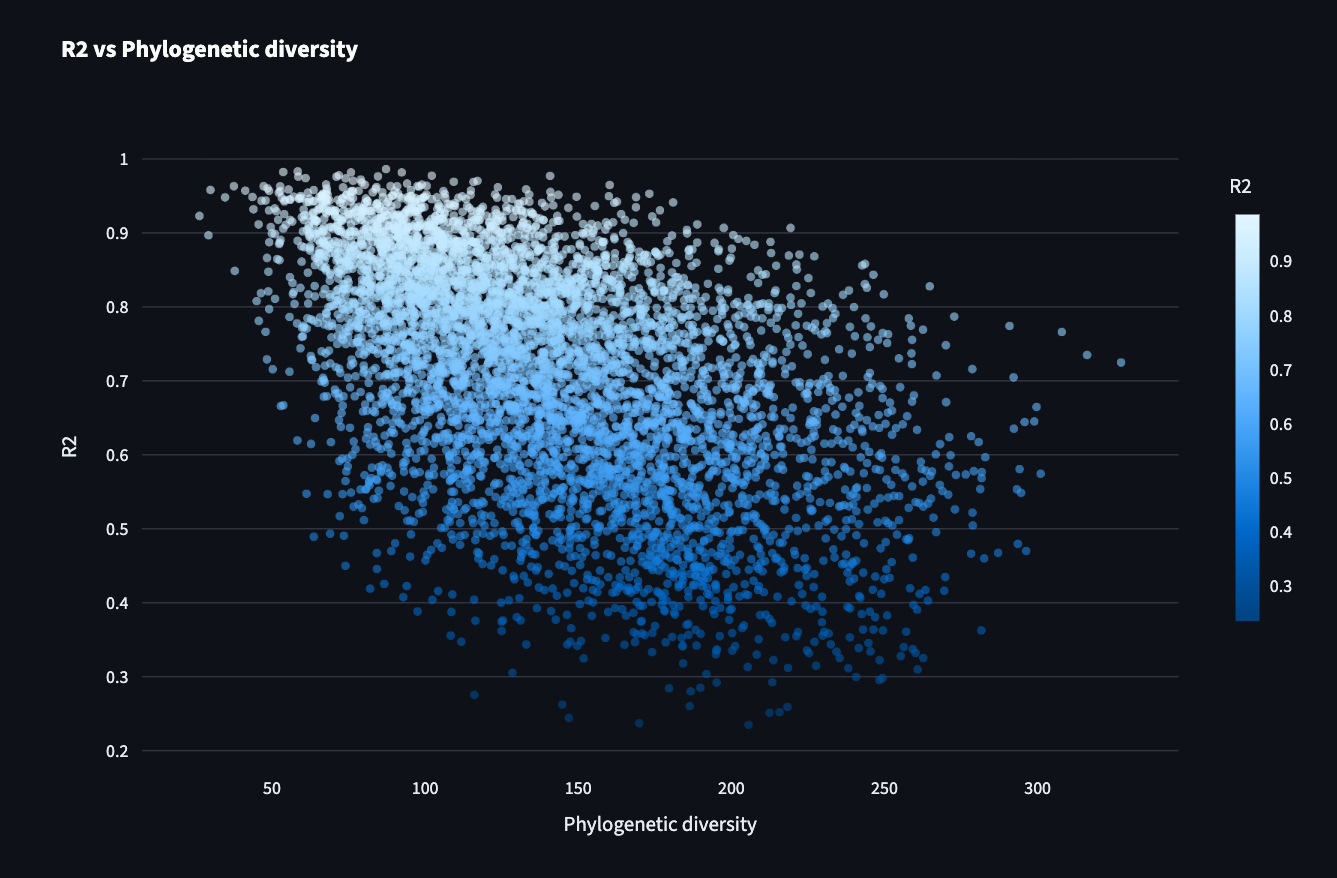
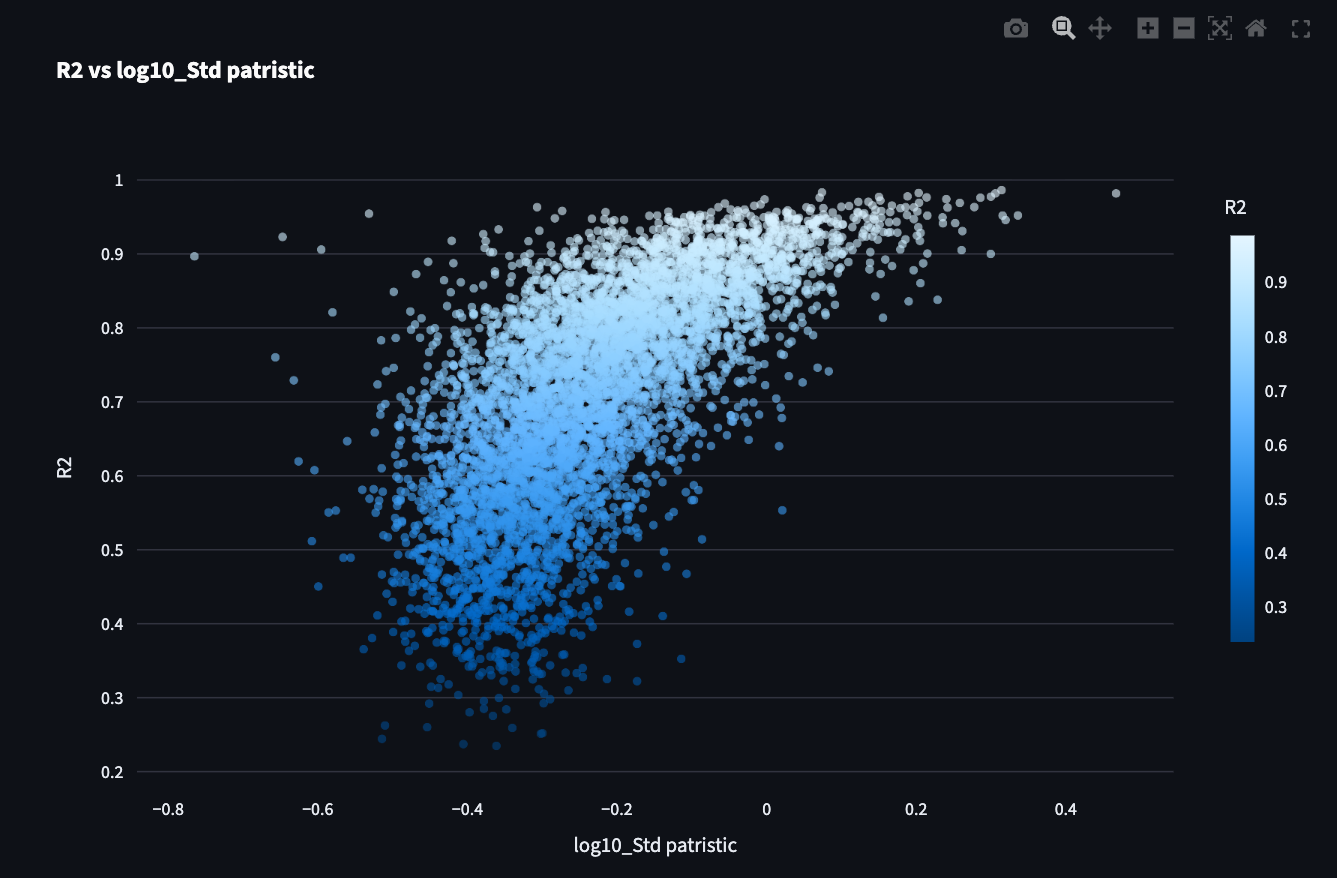

* Together, these two parameters explain 60% of variance
* Discuss the interpretation of these two metrics
    * tldr is: MSA pairformer best captures evolutionary distances when phylogenetic diversity is low overall, but where there is significant variation in patristic distance.

I can explain 60% of the variation with these two parameters

**Without even running the MSA through the model--just by looking at the tree--I can tell how well the sequence weights can model phylogenetic distance**

## Correspondence to downstream task success

These sequence weights aren't designed to predict evolutionary distances, they're model intermediates that dictate layer-by-layer how much the query should attend to each the sequences in the MSA.

IF THE MODEL CAN EXPLAIN EVOLUTIONARY DISTANCES WELL, DOES THAT MEAN DOWNSTREAM PERFORMANCE WILL BE GOOD?

CONVERSELY, IF THE MODEL STRUGGLES TO MODEL THE EVOLUTIONARY DISTANCES, DOES THAT MEAN DOWNSTREAM PERFORMANCE WILL BE BAD?

:::{.callout-note}
TODO I don't love this section. Or, at least, it's a lot of computation that ultimately leads to a result that makes sense intuitively.
:::

don't just predict evolutionary distances, they were model wasn't created to predict evolutionary distances. The sequence weighting scheme used by the model 

We've characterized how well sequence weights can be used to predict evolutionary distance, giving us insight into which MSAs the model is able to accurately characterize from an evolutionary context, and the MSAs that it can't.

However, does this reflect real downstream performance?

We'll test this with beta carbon contact prediction.

In [ ]:
# | code-fold: true
# | code-summary: Downloading/fetching PDBs
from analysis.open_protein_set import fetch_pdbs

pdb_dir = uniclust30_dir / "pdbs"
pdb_paths = fetch_pdbs(msas_depth_200.keys(), pdb_dir)

In [ ]:
# | code-fold: true
# | code-summary: Calculating beta-carbon contacts from structures
from analysis.structure import load_structure, split_structure_by_atom_type

angstrom_cutoff = 8.0

def euclidean_distance_tensor(coords: torch.Tensor) -> torch.Tensor:
    return torch.linalg.norm(coords[:, None, :] - coords[None, :, :], axis=-1)

cb_contacts_pdb = {}
for query, pdb_path in progress(pdb_paths.items(), desc="Calculating CB contacts"):
    _, cb_coords, _, _ = split_structure_by_atom_type(load_structure(pdb_path))
    cb_dist = euclidean_distance_tensor(cb_coords)
    cb_contacts_pdb[query] = cb_dist < angstrom_cutoff

In [ ]:
# | code-fold: true
# | code-summary: Predicting beta-carbon contacts with MSA Pairformer

from analysis.pairformer import calculate_cb_contacts

cb_contacts_depth_200_path = uniclust30_dir / "cb_contacts_depth_200.pt"

# When running on Modal, calculate_cb_contacts serializes MSAs to send to remote GPU workers.
# Serializing all MSAs at once exceeds Modal's serialization limits, so we batch into groups
# of 1000. This constraint is specific to Modal's RPC layer. This batching choice is unnecessary
# yet harmless for local execution.
cb_contacts_depth_200 = {}
batch_size = 250

_msa_items = list(msas_depth_200.items())

if cb_contacts_depth_200_path.exists():
    cb_contacts_depth_200 = torch.load(cb_contacts_depth_200_path, weights_only=True)
else:
    for batch_start in progress(
        range(0, len(_msa_items), batch_size), desc="Predicting CB contacts"
    ):
        _batch_msas = dict(_msa_items[batch_start : batch_start + batch_size])
        _batch_cb_contacts = calculate_cb_contacts(_batch_msas)
        cb_contacts_depth_200.update(_batch_cb_contacts)

    torch.save(cb_contacts_depth_200, cb_contacts_depth_200_path)

In [ ]:
# | code-fold: true
from analysis.structure import calculate_long_range_p_at_l

queries_with_missing_pdb_residues = []
p_at_ls = {}
for query in cb_contacts_depth_200.keys():
    pred_scores = cb_contacts_depth_200[query].squeeze()
    ground_truth = cb_contacts_pdb[query]

    # Sometimes a residue is missing from the PDB structure,
    # creating a mismatch in the shapes between ground truth
    # and the prediction. We skip these rare instances.
    if pred_scores.size(1) != ground_truth.size(1):
        queries_with_missing_pdb_residues.append(query)
        continue

    p_at_ls[query] = calculate_long_range_p_at_l(
        pred_scores=cb_contacts_depth_200[query].squeeze(),
        ground_truth=cb_contacts_pdb[query],
    )

In [ ]:
results_depth_200_df["P@L"] = results_depth_200_df["Query"].map(p_at_ls)
results_depth_200_df.to_csv("test.tsv", sep="\t", index=False)

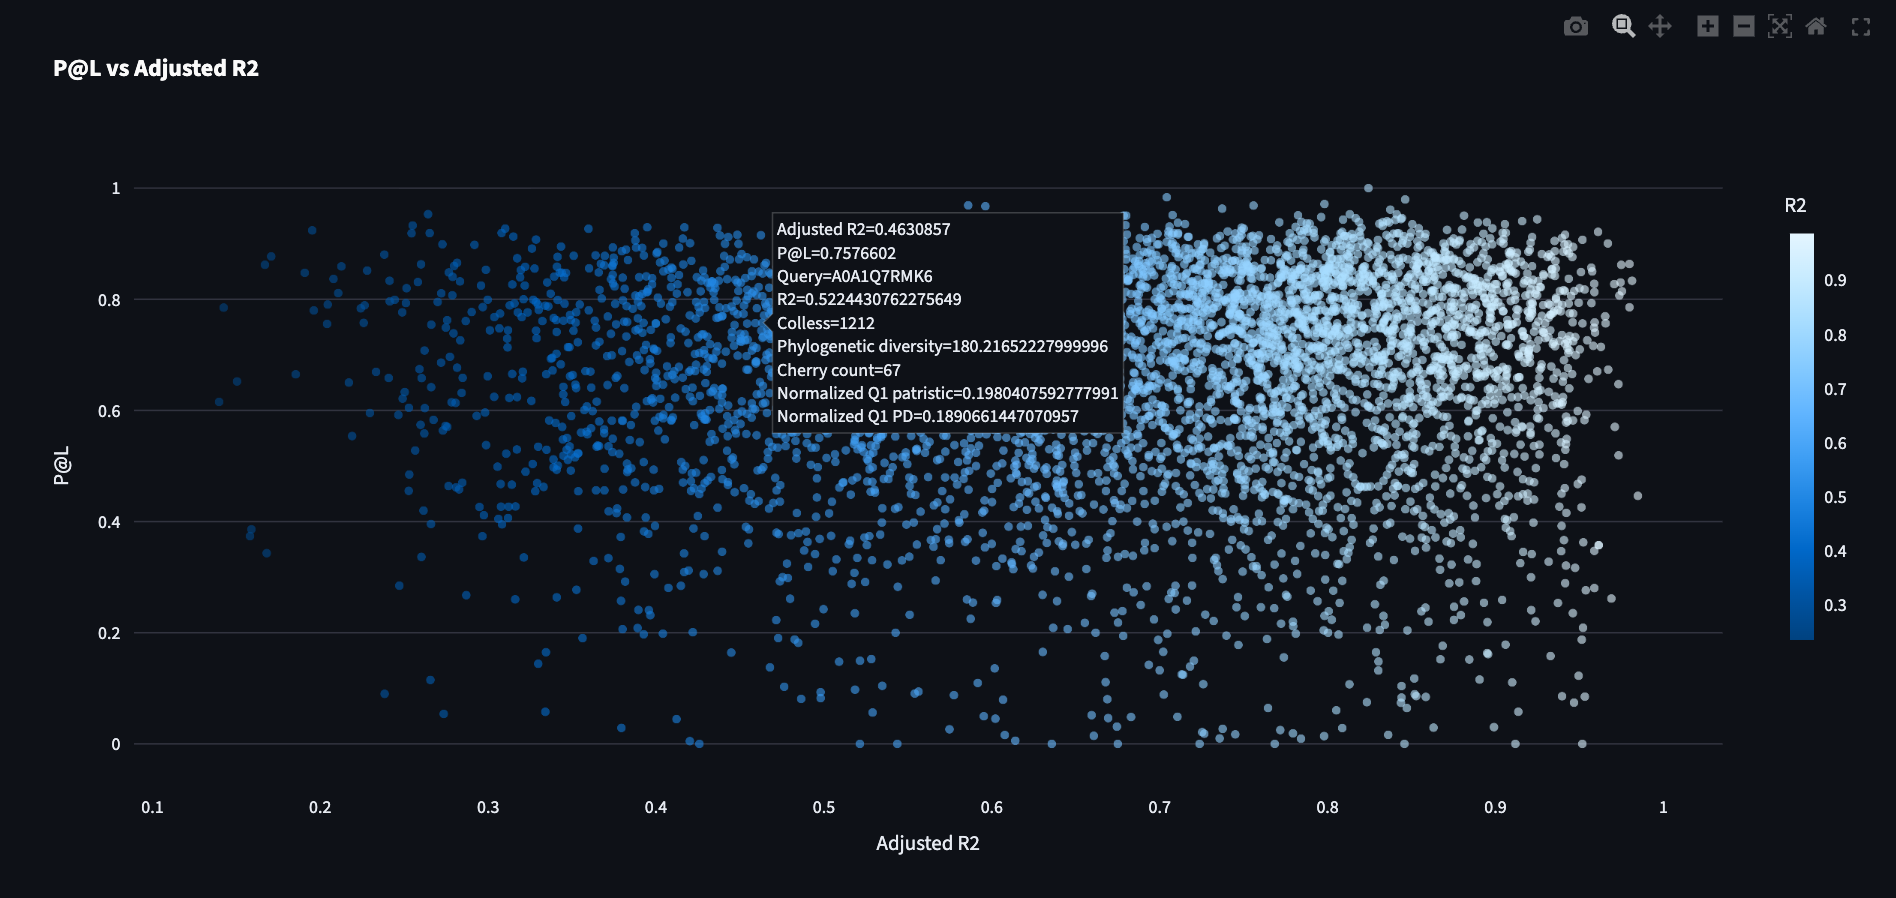

The TLDR is that there is no correspondence at all between contact prediction performance and the phylogenetic reconstruction performance. I guess this isn't very surprising, since there are so many factors that are sort of independent of phylogeny that impact structural accuracy: secondary structure composition, how intrinsically disordered the protein is, etc etc. So maybe this isn't really worth discussing.

## Relation to taxonomy

WIP Currently studying how performance may be dictated/biased by taxonomy of the MSA/query. 

## Residuals

Some MSAs boast high R2, some low. In both cases, it would be interesting to study the residuals of individual members of each MSA so we can determine whether specific portions of the tree are easy to predict, and others harder. This was the suggestion by Austin and supported by Ryan during platform group meeting.

## Experimental code below (no need to read)

In [ ]:
%env USE_MODAL=1

from analysis.pairformer import calculate_cb_contacts

ans = calculate_cb_contacts({"Z4X668": msas_depth_200["Z4X668"]})
print(ans)


In [ ]:
from analysis.structure import calculate_long_range_p_at_l

min_seq_sep = 24
pred_scores = ans["Z4X668"].squeeze(0)
ground_truth = cb_contacts["Z4X668"]

calculate_long_range_p_at_l(pred_scores, ground_truth, min_seq_sep)

In [ ]:
from analysis.plotting import tree_style_with_highlights

def visualize_tree(query):
    tree = trees_depth_200[query].copy()
    display(tree.render("%%inline", tree_style=tree_style_with_highlights([query])))

def visualize_patristic_histogram(query):
    tree = trees_depth_200[query].copy()
    distances = get_patristic_distance(tree, query).values
    plt.hist(distances, bins=30)
    plt.show()
    plt.close()

def visualize_layer_correlation(query, layer):
    tree = trees_depth_200[query].copy()
    distances = get_patristic_distance(tree, query).values
    weights = seq_weights_depth_200[query].clone()
    plt.scatter(weights[:, layer] / weights[:, layer].median(), distances)
    plt.xlabel("Weights")
    plt.ylabel("Distance")
    plt.show()
    plt.close()

def visualize_expected_vs_actual(query):
    tree = trees_depth_200[query].copy()
    weights = seq_weights_depth_200[query].clone()[1:, :]
    dist_to_query = get_patristic_distance(tree, query)[msas_depth_200[query].ids_l].values
    dist_to_query = dist_to_query[dist_to_query > 0]
    model, anova_importance = regress_and_analyze_features(weights, dist_to_query)

    y_pred = model.fittedvalues
    y_actual = model.model.endog
    rho_spearman, _ = spearmanr(y_pred, y_actual)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(y_actual, y_pred, alpha=0.5, s=50)

    min_val = min(y_actual.min(), y_pred.min())
    max_val = max(y_actual.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='1:1 line')

    ax.set_xlabel('Actual Values', fontsize=12)
    ax.set_ylabel('Predicted Values', fontsize=12)
    ax.set_title(f'Predicted vs Actual\nR² = {model.rsquared_adj:.4f}\nSpearman = {rho_spearman}', fontsize=14)
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal', adjustable='box')

    plt.tight_layout()
    plt.show()
    plt.close()


In [ ]:
visualize_tree("A0A0Q9Y1Y1")
visualize_expected_vs_actual("A0A0Q9Y1Y1")
print("----------")
visualize_tree("A0A2S2CVC9")
visualize_expected_vs_actual("A0A2S2CVC9")
print("----------")
visualize_tree("A0A1B1TWK4")
visualize_expected_vs_actual("A0A1B1TWK4")


In [ ]:
visualize_tree("A0A2D5IF98")
visualize_expected_vs_actual("A0A2D5IF98")
print("--------")
visualize_tree("A0A101TAV6")
visualize_expected_vs_actual("A0A101TAV6")
print("--------")
visualize_tree("A0A0C9T0J9")
visualize_expected_vs_actual("A0A0C9T0J9")
print("--------")

In [ ]:
query = "A0A2A3C968"
visualize_tree(query)
visualize_expected_vs_actual(query)
print("--------")

In [ ]:
query = "A0A063UGB9"
visualize_tree(query)
visualize_expected_vs_actual(query)
print("--------")
query = "E0YPD8"
visualize_tree(query)
visualize_expected_vs_actual(query)
print("--------")
query = "G9PAF8"
visualize_tree(query)
visualize_expected_vs_actual(query)
print("--------")
query = "L5L908"
visualize_tree(query)
visualize_expected_vs_actual(query)
print("--------")
query = "A0A1C6I8U6"
visualize_tree(query)
visualize_expected_vs_actual(query)
print("--------")

In [ ]:
# gap fraction
queries = [
"A0A1G9M6E8",
"A0A1G4IGJ9",
"G9M5V7",
"A0A0L8V725",
"A0A1H1XVQ1",
"A0A2V4VUU1",
"I8QNJ9",
"Q4D1U2",
"A0A231TZH7",
"A0A2D5IF98",
"A0A177UNQ9",
"A0A1C6S9K5",
"U9UUC8",
"A0A2W1TZ92",
"D9ZIP0",
"A0A078LMT5",
"Q3F084",
"A0A1R2CEV7",
"A0A2E4I0A1",
"A0A2K1JPT6",
"A0A2D9AAZ5",
"A0A081A5J8",
"A0A0A7PL31",
"S5ZXA0",
"A0A1H3BLN1",
"A0A150IYC4",
"A0A2T0TIX6",
"A0A1V9BBM9",
"A0A2X2P6A0",
"M5XMC3",
"A0A1Q8LIN4",
"A0A0U3B336",
"A0A2R6W5K4",
"A0A254U7T2",
"A0A1Z5JF18",
"E4LFF0",
"A0A1I5C885",
"A0A2V7NTA9",
"A0A200QCD8",
"A0A2I7TA08",
"B9X7R0",
"A0A0U2UBM5",
"A0A0U0Z9Z9",
"A0A2A2F874",
"B1VH18",
"A0A2N3BGP4",
"C7Z0V6",
"A0A0N5BL92",
"A0A2D1L1Z9",
"T5DKP2",
"A0A0M1KHJ5",
"A0A1I3ZXY3",
"A0A0W0ZB52",
"A0A1N6L9P7",
]
for query in queries:
    print(query)
    visualize_tree(query)
    visualize_expected_vs_actual(query)
    #visualize_patristic_histogram(query)

In [ ]:
# max/median ratio
queries = [
"A0A2D5IF98",
"A0A1G9M6E8",
"Q8QDJ1",
"B9UFU2",
"Q76180",
"A0A220MIY8",
"C7Z0V6",
"A0A0U0Z9Z9",
"B9W5C9",
"A0A1D1Z2Z6",
"A0A1V0FJM2",
"A0A287WJG7",
"A0A1H1DVN5",
"Q5B2J4",
"A0A2E4I0A1",
"A0A200QCD8",
"A0A231TZH7",
"A0A1H8X7K2",
"A0A246FPQ4",
"F8H080",
"B1VH18",
"A0A0H3K5U8",
"A0A2N8GM73",
"U2SPB7",
"A0A1I3ZXY3",
"A0A2W1TZ92",
"B9BSY2",
"U9UUC8",
"A0A1H9GVV6",
"A0A1D6HG15",
"A0A0L8V725",
"A0A2X1YNN8",
"A0A2M8G7A7",
"F0JHX6",
"A0A0N5BL92",
"A0A2U3C4I7",
"A0A2K1JPT6",
"D9ZIP0",
"A0A1E3KCR1",
"A0A1H3HTJ0",
"A0A1C0XP85",
"A0A1H1FJG8",
"A0A2V4VUU1",
"H1KD77",
"A0A0U2UBM5",
"A0A0N1L273",
"A0A1E4BGS6",
"A0A078LMT5",
"D0PUM7",
"M5XMC3",
"A0A2X0XLJ2",
"A0A2E1RV40",
"A0A1X0XN98",
"A0A0X3VUL7",
"A0A067GTK6",
"A0A096URA9",
"A0A2H4WAB5",
"A0A101TAV6",
"A0A2G7DT92",
"A0A2V8ILG1",
"A0A1H1XVQ1",
"A0A0M4GL07",
"A0A177UNQ9",
"Q3F084",
"I8QNJ9",
"A0A2E5YIE2",
"A0A0P5VZQ3",
"R6GI47",
"A0A2R6W5K4",
"C4M7L0",
]
for query in queries:
    print(query)
    visualize_tree(query)
    visualize_expected_vs_actual(query)
    #visualize_patristic_histogram(query)

In [ ]:
other_queries=[
"A0A2D5IF98",
"A0A1G9M6E8",
"A0A0U0Z9Z9",
"A0A1I3ZXY3",
"C7Z0V6",
"A0A101TAV6",
"A0A0C9T0J9",
"A0A2E1RV40",
"A0A078LMT5",
"A0A1V6MQN7",
"J2RDL3",
"A0A094F652",
"A0A063UGB9",
"A0A127H385",
"A0A0N1L273",
"A0A287JM60",
"U5E9K2",
"A0A1D1Z2Z6",
"A0A0A0REU0",
"Q5B2J4",
"A0A0H3K5U8",
"W5NXD4",
"A0A2P1DQH4",
"A0A1K2EWA1",
"A0A0J9WGS1",
"A0A2T5XTH6",
"H0HUQ4",
"A0A1M6B090",
"S2YN34",
"F8H080",
"A0A0M4NT22",
]
for query in other_queries:
    print(query)
    visualize_tree(query)
    visualize_expected_vs_actual(query)